# Описание задачи и датасета
Необходимо построить рекомендательную систему постов в социальной сети - реализовать сервис, который будет для каждого юзера в любой момент времени возвращать посты, которые пользователю покажут в его ленте.

Для оценки системы используется метрика средний hitrate@5, для построения модели - контентный подход. 

Поскольку целевая метрика принимает значение 1, если среди предложенных рекомендаций хотя бы 1 получила в итоге like от пользователя, в задаче классификации будет использоваться метрика recall. Для рекомендации среди прогнозов модели будут отобраны 5 постов с наибольшей вероятностью клика.
В модели не используются текстовые признаки, поэтому качество метрики, которое необходимо было достичь - 0.4

В качестве базовых сырых данных используются подготовленные заранее таблицы.

Таблица **user_data** содержит информацию о всех пользователях соц.сети:
- **age** -	Возраст пользователя (в профиле)
- **city** -	Город пользователя (в профиле)
- **country**	- Страна пользователя (в профиле)
- **exp_group**	- Экспериментальная группа: некоторая зашифрованная категория
- **gender**	- Пол пользователя
- **id** -	Уникальный идентификатор пользователя
- **os** - Операционная система устройства, с которого происходит пользование соц.сетью
- **source** -	Пришел ли пользователь в приложение с органического трафика или с рекламы
 

Таблица **post_text_df** cодержит информацию о постах и уникальный ID каждой единицы с соответствующим ей текстом и топиком
- **text**	- Текстовое содержание поста
- **topic**	- Основная тематика
 

Таблица **feed_data** cодержит историю о просмотренных постах для каждого юзера в изучаемый период.
- **timestamp**	- Время, когда был произведено действие
- **user_id**	- id пользователя, который совершил просмотр
- **post_id**	- id просмотренного поста
- **action**	- Тип действия: просмотр или лайк
- **target** -	1 у просмотров, если почти сразу после просмотра был совершен лайк, иначе 0. У действий like пропущенное значение.

In [ ]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sqlalchemy import create_engine
from sklearn.metrics import classification_report, recall_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_validate
from catboost import CatBoostClassifier
from database import engine

### Посмотрим на данные

In [ ]:
### Данные по пользователям
user_info = pd.read_sql("""SELECT * FROM public.user_data""", con=engine)
user_info.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [ ]:
### Данные по постам
posts_info = pd.read_sql("""SELECT * FROM public.post_text_df""", con=engine)
posts_info.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [ ]:
### Данные по просмотрам/лайкам пользователей. Поскольку записей много, возьмем часть данных. 
### Т.к. информация о наличии лайка содержится в колонке target, будем использовать только action = 'view' чтобы не дублировать данные

feed_data = pd.read_sql("""SELECT * FROM public.feed_data WHERE action = 'view' LIMIT 5000""",
    con=engine)

feed_data.head()

,timestamp,user_id,post_id,action,target
0,2021-12-27 10:38:54,92177,3543,view,0
1,2021-12-27 10:39:16,92177,1045,view,0
2,2021-12-27 10:41:19,92177,1361,view,0
3,2021-12-27 10:42:57,92177,842,view,1
4,2021-12-27 10:44:27,92177,4740,view,0


In [ ]:
### Выгрузим не рандомные данные, а по 20 постов каждого пользователя
feed_data = pd.read_sql(
    """SELECT timestamp, user_id, post_id, target FROM
      (SELECT timestamp, user_id, post_id, target, 
      ROW_NUMBER() OVER(PARTITION BY user_id ORDER BY timestamp DESC) AS post_num
      FROM public.feed_data 
      WHERE action = 'view') t
    WHERE post_num <= 20""",
    con=engine)

In [ ]:
### Соберем данные в 1 датафрейм
df = feed_data.merge(user_info).merge(posts_info)
df.head()

,timestamp,user_id,post_id,target,gender,age,country,city,exp_group,os,source,text,topic
0,2021-12-27 10:38:54,92177,3543,0,1,22,Russia,Stavropol,1,Android,ads,Asked my secretary and trainee to book in CBDs...,covid
1,2021-10-17 14:51:14,11920,3543,0,1,21,Ukraine,Chernivtsi,3,Android,ads,Asked my secretary and trainee to book in CBDs...,covid
2,2021-12-04 16:45:20,64055,3543,0,0,16,Russia,Nevinnomyssk,4,iOS,ads,Asked my secretary and trainee to book in CBDs...,covid
3,2021-10-24 07:29:29,92186,3543,0,0,21,Russia,Kolpino,3,iOS,ads,Asked my secretary and trainee to book in CBDs...,covid
4,2021-11-03 18:09:10,92190,3543,0,0,17,Russia,Donskoy,4,Android,ads,Asked my secretary and trainee to book in CBDs...,covid


Добавим новые признаки. 
Для каждого пользователя вычислим его общий суммарный ctr (отношение количества лайков к показам) как показатель того, насколько часто пользователь в принципе ставит лайки. Выделим из timestamp час и день недели.

In [ ]:
data_ctr= pd.read_sql('''
SELECT user_id, 10000*sum(target)/count(target) as ctr
FROM public.feed_data 
WHERE action = 'view'
group by user_id;
''', con=engine)

df = df.merge(data_ctr)
df['day_of_week'] = pd.DatetimeIndex(df['timestamp']).day_of_week
df['hour'] = pd.DatetimeIndex(df['timestamp']).hour

df.head()

,timestamp,user_id,post_id,target,gender,age,country,city,exp_group,os,source,text,topic,ctr,day_of_week,hour
0,2021-12-27 10:38:54,92177,3543,0,1,22,Russia,Stavropol,1,Android,ads,Asked my secretary and trainee to book in CBDs...,covid,1780,0,10
1,2021-12-27 10:39:16,92177,1045,0,1,22,Russia,Stavropol,1,Android,ads,Sainsburys Labour election gift\n\nScience Min...,politics,1780,0,10
2,2021-12-27 10:41:19,92177,1361,0,1,22,Russia,Stavropol,1,Android,ads,Scots smoking ban details set out\n\nSmoke-fre...,politics,1780,0,10
3,2021-12-27 10:42:57,92177,842,1,1,22,Russia,Stavropol,1,Android,ads,Media seek Jackson juror notes\n\nReporters co...,entertainment,1780,0,10
4,2021-12-27 10:44:27,92177,4740,0,1,22,Russia,Stavropol,1,Android,ads,If youre looking for a Hollywood action packed...,movie,1780,0,10


### Посмотрим распределение признаков для лайкнувших/не лайкнувших пользователей. Страна и город не рассматриваются, поскольку имеют слишком много уникальных значений

Отношение количества наблюдений первого класса к нулевому: 0.1372491398984755


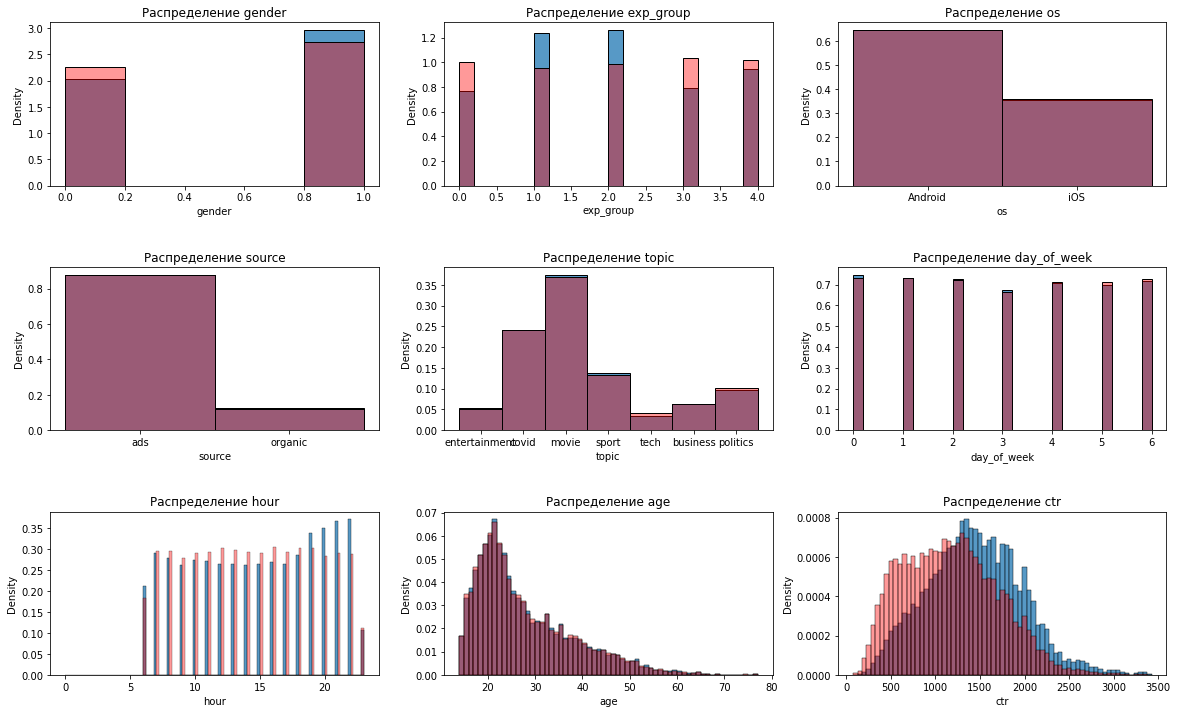

In [ ]:
cat_cols_to_plot = ['gender',  'exp_group', 'os', 'source', 'topic', 'day_of_week', 'hour']
num_cols_to_plot = ['age', 'ctr']

liked = df[df['target'] == 1]
not_liked = df[df['target'] == 0]

### Так же проверим дисбаланс
ratio = liked.shape[0]/not_liked.shape[0]
print(f'Отношение количества наблюдений первого класса к нулевому: {ratio}')

bins_for_num_cols = {'age':1, 'ctr':50}

fig = plt.figure() 
fig.set_size_inches(20, 12) 
for i, col in enumerate(cat_cols_to_plot + num_cols_to_plot): 
    ax_ = fig.add_subplot(3, 3, i+1)
    plt.title(f'Распределение {col}')
    if col in cat_cols_to_plot:
      sns.histplot(liked[col], label = 'Лайкнули', stat='density', binwidth = 0.2)
      sns.histplot(not_liked[col], label = 'Не Лайкнули', alpha=0.4, stat='density', color='red', binwidth = 0.2)  
    else:
      sns.histplot(liked[col], label = 'Лайкнули', stat='density', binwidth = bins_for_num_cols[col])
      sns.histplot(not_liked[col], label = 'Не Лайкнули', alpha=0.4, stat='density', color='red', binwidth = bins_for_num_cols[col]) 
    plt.subplots_adjust(hspace=0.5)

Визуально видно, что ctr точно имеет влияние на таргетную переменную. 
Также видим сильный дисбаланс классов, отношение кол-ва наблюдений 1го класса к нулевому (ratio) - 0.137 

In [ ]:
### Отсортируем наблюдения по времени, удалим лишние колонки
df = df.sort_values(by='timestamp')
df = df.drop(['timestamp', 'user_id', 'text'], axis=1)
df = df.set_index(['post_id'])

### Для начала попробуем построить модель с помощью random forest

In [ ]:
### Выделим 20% выборки на тест, сплитуем по времени - в тест идет 20% последних наблюдений 
test_size = int(df.shape[0]*0.2)
X_train = df.iloc[:-test_size].drop('target', axis=1)
y_train = df.iloc[:-test_size]['target']
X_test = df.iloc[-test_size:].drop('target', axis=1)
y_test = df.iloc[-test_size:]['target']

In [ ]:
### Разделим колонки для ohe и mean-target кодирования

object_cols = [el for el in list(X_train.columns) if el not in ['ctr', 'age']]

cols_for_ohe = [x for x in object_cols if X_train[x].nunique() < 5]
cols_for_mte = [x for x in object_cols if X_train[x].nunique() >= 5]

cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]

t = [
    ('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx),
    ('MeanTargetEncoder', TargetEncoder(), cols_for_mte_idx)
]

col_transform = ColumnTransformer(transformers=t)

In [ ]:
%%time
### Обучаем модель

pipe_rf = Pipeline([("column_transformer", col_transform),
                    ("random_forest", RandomForestClassifier(class_weight='balanced'))])

pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)
recall_score(y_test, y_pred_rf)

CPU times: user 9min 11s, sys: 4.5 s, total: 9min 15s
Wall time: 9min 17s


0.1557993560780282

Получаем низкий recall даже с balanced class_weight, попробуем улучшить ситуацию с помощью оверсемплинга с учетом ближайших соседей - smote

In [ ]:
%%time
pipe_rf_smote = imbpipeline([("column_transformer", col_transform),
                    ("SMOTE", SMOTE()),
                    ("random_forest", RandomForestClassifier())])

pipe_rf_smote.fit(X_train, y_train)
y_pred_rf_smote = pipe_rf_smote.predict(X_test)
recall_score(y_test, y_pred_rf_smote)

CPU times: user 14min 1s, sys: 6.23 s, total: 14min 8s
Wall time: 14min 5s


0.15891020169803693

Recall не улучшился, попробуем другой класс моделей

### Используем Catboost

In [ ]:
%%time
cboost = CatBoostClassifier(verbose=0, scale_pos_weight=round(1/ratio))

print(object_cols)
cboost.fit(X_train,
           y_train,
           cat_features=object_cols)

y_pred = cboost.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

feat_imp_list = list(zip ( list(cboost.feature_importances_) , cboost.feature_names_) )
feature_imp_df = pd.DataFrame(sorted(feat_imp_list, key=lambda x: x[0], reverse=True) , columns = ['feature_value','feature_name'])
feature_imp_df

['gender', 'country', 'city', 'exp_group', 'os', 'source', 'topic', 'day_of_week']
              precision    recall  f1-score   support

           0     0.9378    0.5321    0.6789    578898
           1     0.1649    0.7235    0.2686     73922

    accuracy                         0.5538    652820
   macro avg     0.5513    0.6278    0.4738    652820
weighted avg     0.8503    0.5538    0.6325    652820

CPU times: user 5min 56s, sys: 14.5 s, total: 6min 10s
Wall time: 5min 29s


,feature_value,feature_name
0,36.950676,ctr
1,26.324856,age
2,20.167938,topic
3,8.987793,hour
4,3.235599,exp_group
5,1.686840,day_of_week
6,1.649306,city
7,0.595657,country
8,0.302120,gender
9,0.074598,os


Получаем recall 0.72, что значительно лучше. Если рассмотреть важность признаков, то видим, что большая часть признаков не вносит вклад в предсказание - выделим топ-4 признака для использования в модели и попробуем пройтись по сетке параметров модели, чтобы найти более оптимальные и улучшить качество. В грид-сёрче используем временную кросс-валидацию

In [ ]:
%%time
X_train_1 = X_train[['age', 'ctr', 'topic', 'hour', 'target']]
# y_train не меняется
X_test_1 = X_test[['age', 'ctr', 'topic', 'hour', 'target']]
# y_test не меняется

parameters = {'n_estimators': np.linspace(10, 510, 3), 
              'learning_rate': np.linspace(0.01, 0.5, 5),
              'depth': np.linspace(3, 9, 3)}     
                                  
tscv = TimeSeriesSplit(n_splits=3)
gs_cboost = GridSearchCV(estimator=cboost, param_grid = parameters, cv = tscv, scoring = 'recall')
gs_cboost.fit(X_train_1, y_train, cat_features=['topic'])
y_pred_1 = gs_cboost.predict(X_test_1)

print(f'Recall: {recall_score(y_test, y_pred_1)}')

Recall: 0.7835691675008793
CPU times: user 1h 7min 12s, sys: 8min 13s, total: 1h 15min 26s
Wall time: 50min 10s


Видим, что качество выросло до 0.78. Сохраняем эту модель для использования в сервисе

In [ ]:
gs_cboost.best_estimator_.save_model('model',
           format="cbm")

При тестировании сервиса, т.е. переходя от задачи классификации к изначальной задаче показа рекомендаций пользователям - данная модель показывает hitrate@5 = 0.438 при нужном пороге качества 0.4 
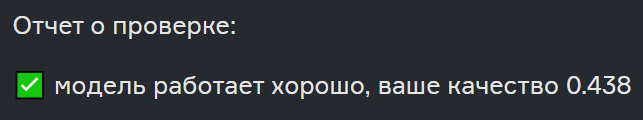

Запишем признаки в бд - для пользователей добавим информацию о среднем ctr, для постов - дату выхода поста, чтобы по возможности показывать пользователям более свежие посты

In [ ]:
### Информация о пользователях
try:
    pd.read_sql('''
    CREATE TABLE aka_features_users AS

    SELECT user_id, age, ctr
    FROM 
    (SELECT user_id, age FROM public.user_data) t_user
    JOIN 
    (SELECT user_id, 10000*SUM(target)/COUNT(target) AS ctr
    FROM public.feed_data 
    WHERE action = 'view'
    GROUP BY user_id) t_ctr 
    USING(user_id)
    ''', con=engine)
except:
    pass

### Информация о постах
try:
    pd.read_sql('''
    CREATE TABLE aka_features_posts AS

    SELECT post_id, topic, release_date
    FROM 
    (SELECT post_id, topic FROM public.post_text_df) t_post
    JOIN 
    (SELECT post_id, MIN(timestamp) AS release_date
    FROM public.feed_data 
    GROUP BY post_id) t_date
    USING(post_id)
    ''', con=engine)
except:
    pass